In [1]:
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle

In [2]:
from dateutil.parser import parse
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline
pd.options.mode.chained_assignment = None #to run loop quicker without warnings

In [3]:
#name = 'bpi_2012'
#name = 'bpi_2013'
name = 'small_log'
#name = 'large_log'

args = {
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'input_dir': '../input/{}/'.format(name),  
    'train_pct': 0.6,
    'val_pct': 0.2,
    'anomaly_pct': 0.1,
    'scaler': 'standardization',
}

args = argparse.Namespace(**args)

In [4]:
if not os.path.isdir('../input/'):
    os.makedirs('../input/')
    
if not os.path.isdir(args.input_dir):
    os.makedirs(args.input_dir)

In [5]:
sys.path.insert(0, './../utils/')
from utils import *

In [6]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    activity_label_test = pickle.load(f)
    time_label_test = pickle.load(f)
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    mean_value = pickle.load(f)
    std_value = pickle.load(f)
    cols = pickle.load(f)
    statistics_storage = pickle.load(f)
    true_time = pickle.load(f)
    true_act = pickle.load(f)
    full_true_time = pickle.load(f)
    full_true_act = pickle.load(f)

# Load data

In [7]:
normal_df_name = os.path.join(args.input_dir, 'normal_df_{}.csv'.format(args.anomaly_pct))
normal_df = pd.read_csv(normal_df_name)

anomalous_df_name = os.path.join(args.input_dir, 'anomolous_df_{}.csv'.format(args.anomaly_pct))
anomalous_df = pd.read_csv(anomalous_df_name)

In [8]:
normal_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration
0,1,Activity A,1970-01-01 09:00:00,0.0,0.0
1,1,Activity B,1970-01-01 10:00:00,3600.0,3600.0
2,1,Activity C,1970-01-01 11:00:00,3600.0,7200.0
3,1,Activity D,1970-01-01 12:00:00,3600.0,10800.0
4,1,Activity E,1970-01-01 13:00:00,3600.0,14400.0


In [9]:
anomalous_df.head()

,CaseID,AnomalousActivity,AnomalousCompleteTimestamp,AnomalousDuration,AnomalousCumDuration,ActivityLabel,TimeLabel
0,1,Activity A,1970-01-01 09:00:00.000000,0.000000,0.000000,0,0
1,1,Activity B,1970-01-01 10:02:46.049539,3766.049539,3766.049539,0,1
2,1,Activity C,1970-01-01 11:11:25.335178,4285.335178,7885.335178,0,1
3,1,Activity A,1970-01-01 12:00:00.000000,3600.000000,10800.000000,1,0
4,1,Activity E,1970-01-01 13:00:00.000000,3600.000000,14400.000000,0,0


# Histogram

In [10]:
def histogram_plot(df, activity):
    selected_df = df[df['Activity']==activity]['Duration']
    selected_df.hist()
    plt.axvline(selected_df.mean(), color='w', linestyle='dashed', linewidth=2)
    plt.axvline(selected_df.mean()+selected_df.std(), color='r', linestyle='dashed', linewidth=2)
    plt.title('Histogram of '+ act)
    plt.savefig(args.input_dir + 'histogram_'+act)
    plt.show()
    plt.close()

In [11]:
act_list = normal_df['Activity'].unique()
print('Activity: {}'.format(act_list))

Activity: ['Activity A' 'Activity B' 'Activity C' 'Activity D' 'Activity E'
 'Activity K' 'Activity G' 'Activity M' 'Activity L' 'Activity I'
 'Activity J' 'Activity N' 'Activity H' 'Activity F']


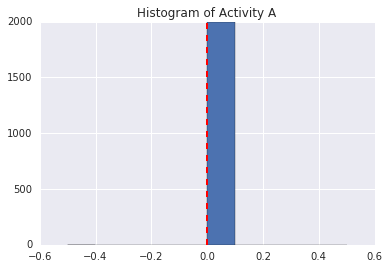

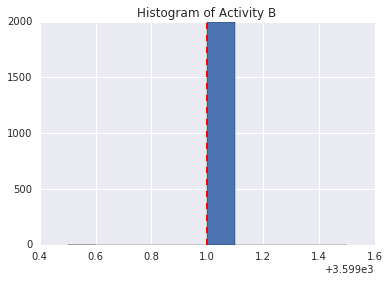

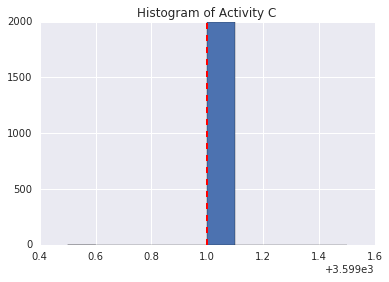

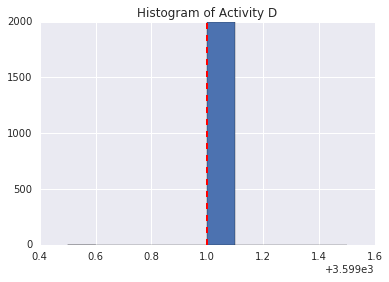

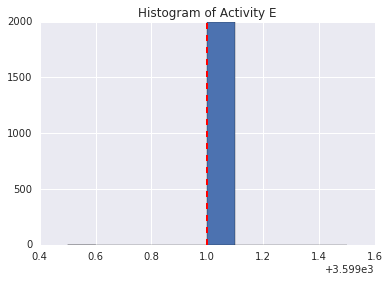

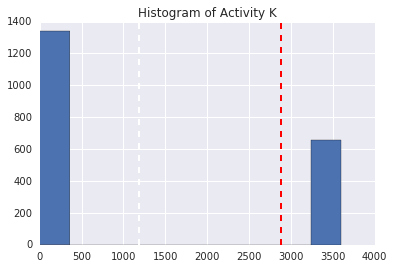

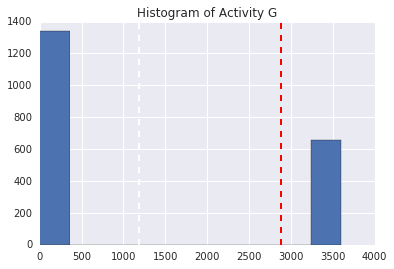

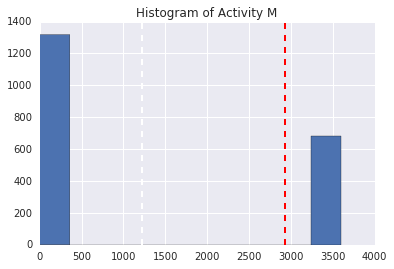

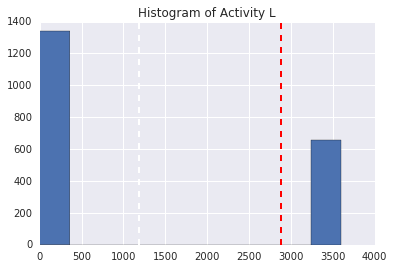

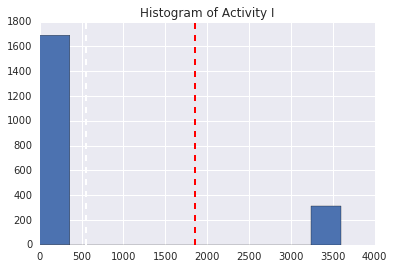

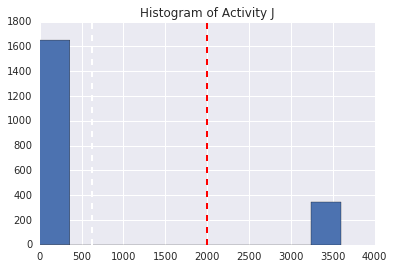

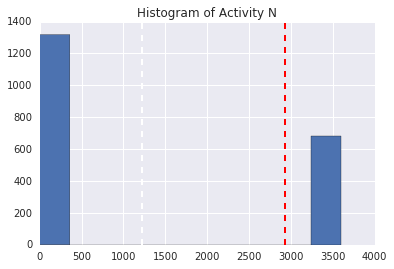

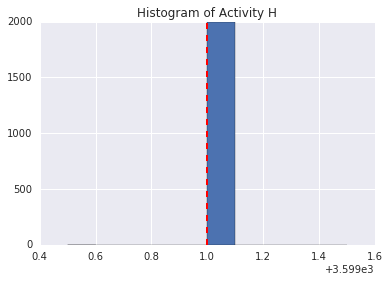

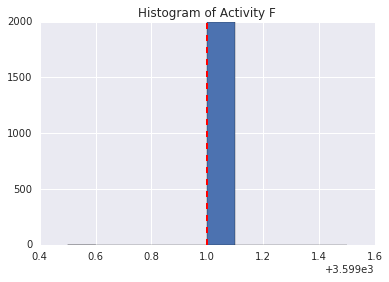

In [12]:
for act in act_list:
    histogram_plot(normal_df, act)

# Duration

## Full set

In [13]:
temp = pd.DataFrame({'Activity': normal_df['Activity'].copy(),
                     'AnomalousDuration': anomalous_df['AnomalousDuration'].copy(),
                     'TimeLabel': anomalous_df['TimeLabel'].copy()})

In [14]:
temp.head()

,Activity,AnomalousDuration,TimeLabel
0,Activity A,0.000000,0
1,Activity B,3766.049539,1
2,Activity C,4285.335178,1
3,Activity D,3600.000000,0
4,Activity E,3600.000000,0


In [15]:
groupByActivity = temp.groupby(['Activity'])

In [16]:
def plotDuration(activity, df, save=False):
    fig, ax = plt.subplots(figsize=(10, 5))
    anomaly = df[df['TimeLabel']==1]
    normal = df[df['TimeLabel']==0]
    ax.plot(anomaly.index, anomaly.AnomalousDuration, marker='o', ms=3.5, linestyle='', color='green', label='Anomalous data: '+str(len(anomaly)))
    ax.plot(normal.index, normal.AnomalousDuration, marker='o', ms=3.5, linestyle='', color='blue', label='Normal data: '+str(len(normal)))
    ax.hlines(statistics_storage[activity]['mean']+statistics_storage[activity]['std'], ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Border')
    plt.title('Duration of '+ activity)
    plt.xlabel('Data point index')
    plt.ylabel('Duration')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save == True:
        plt.savefig(args.input_dir + 'duration_'+act, bbox_inches='tight')
    plt.show()
    plt.close()

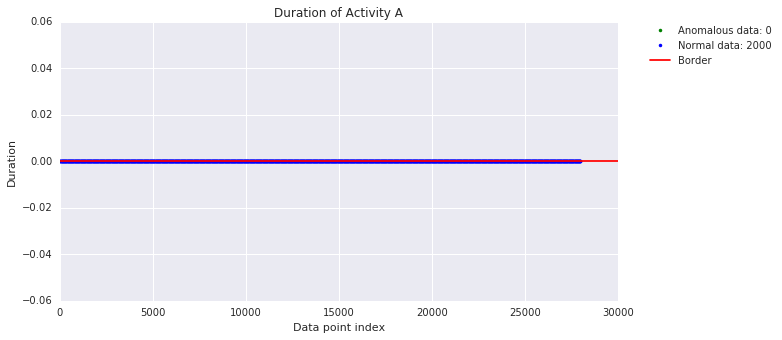

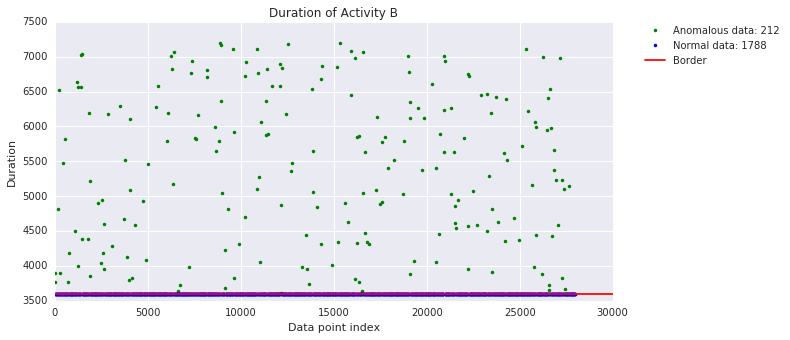

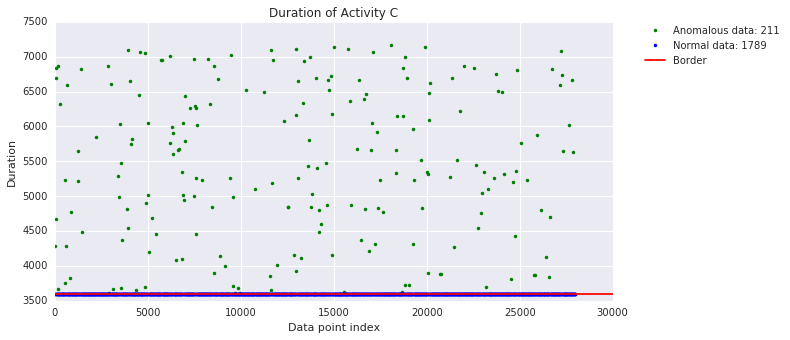

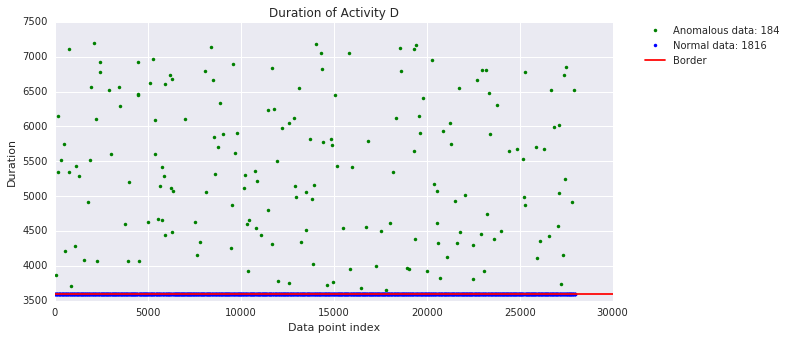

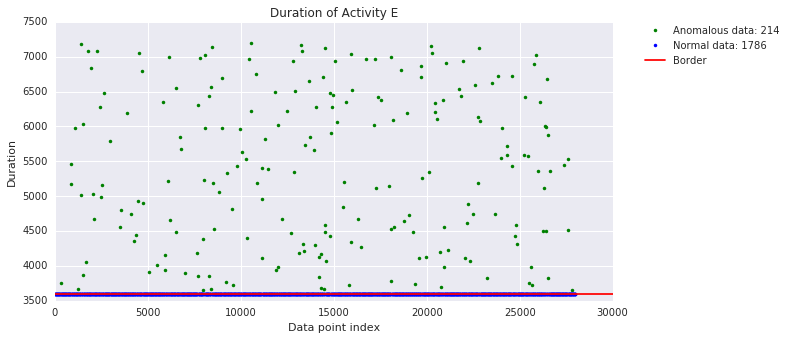

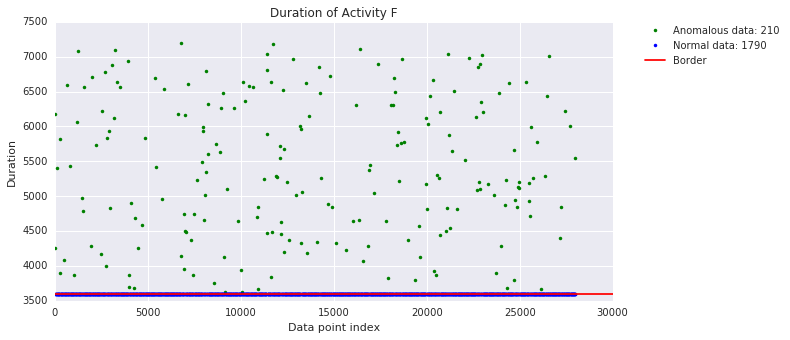

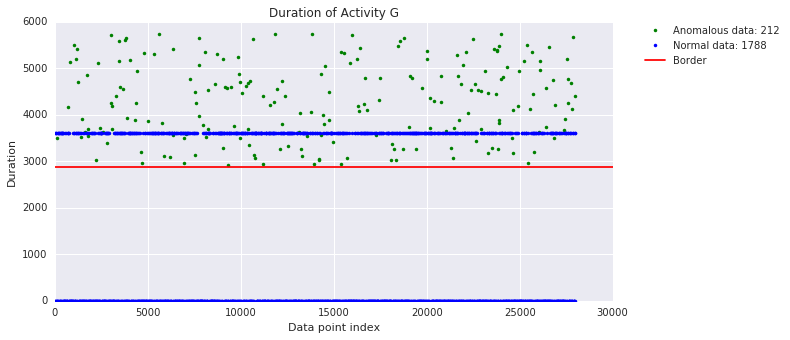

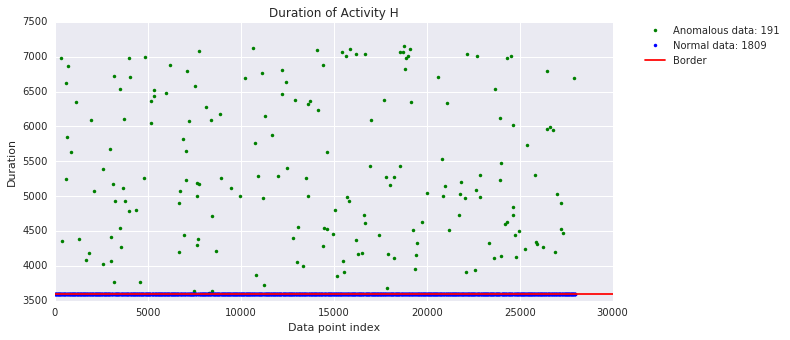

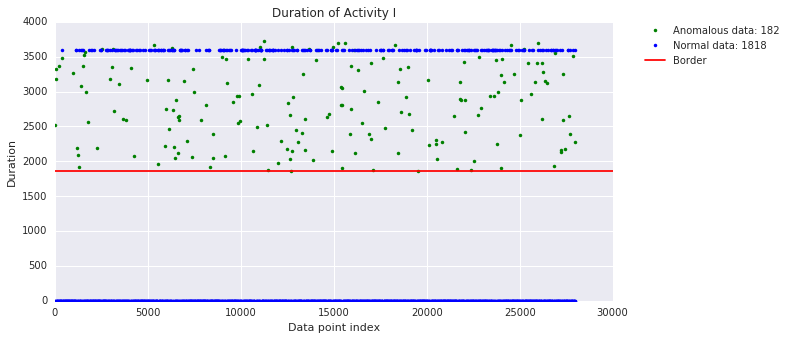

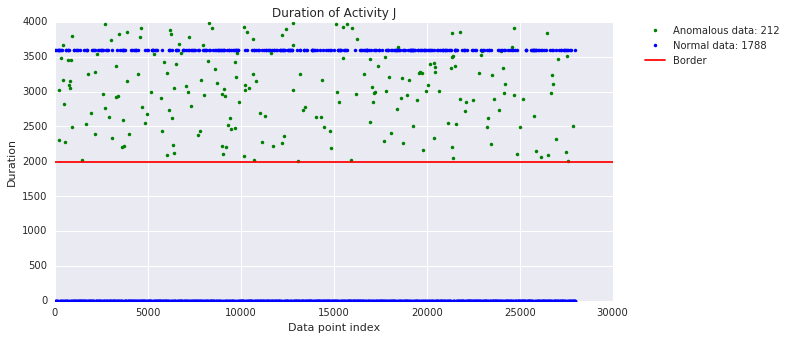

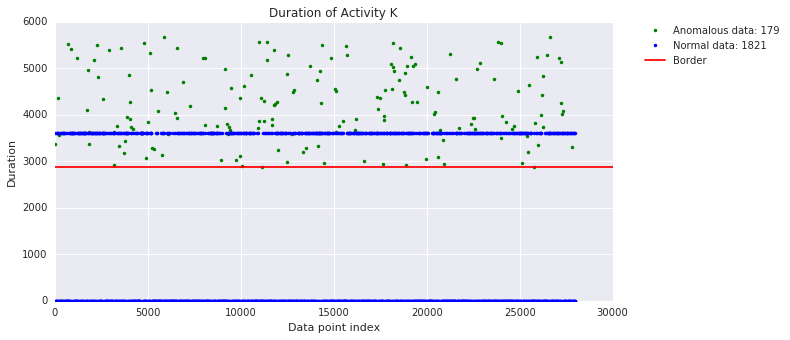

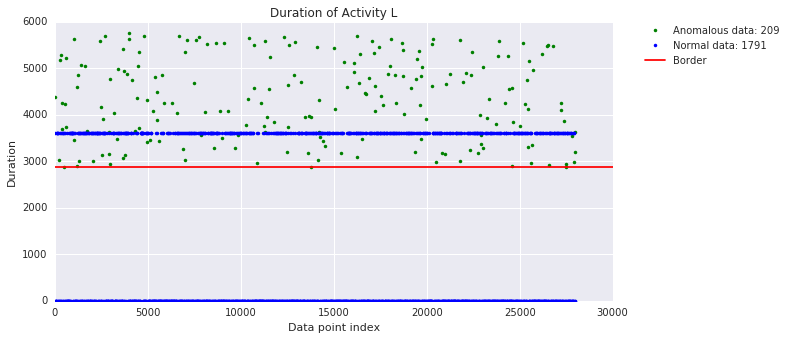

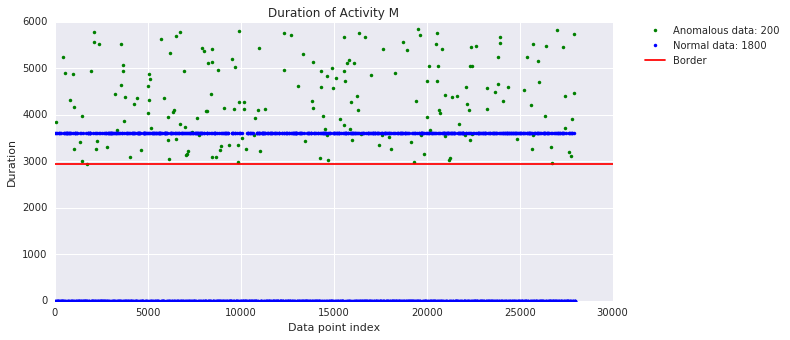

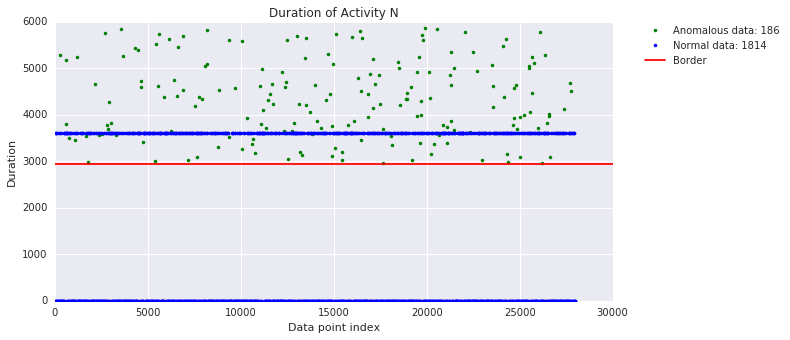

In [17]:
for act, group in groupByActivity:
    plotDuration(act, group, True)

## Test set

In [18]:
temp_test = temp[-test_row_num:]

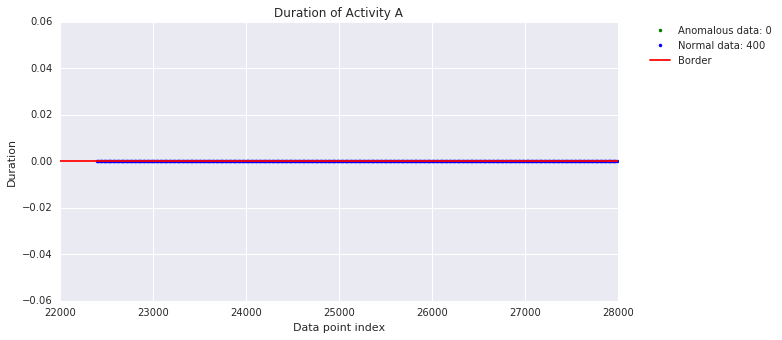

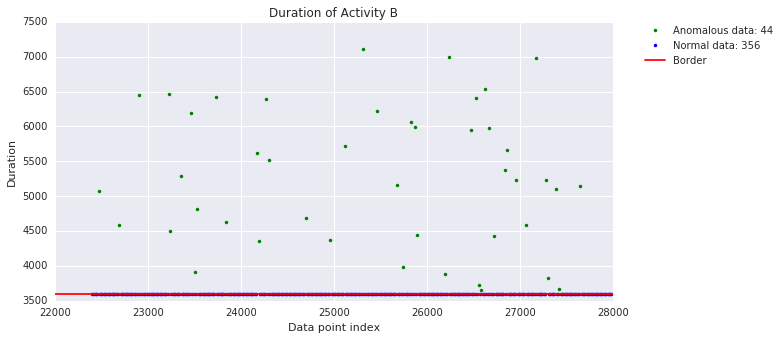

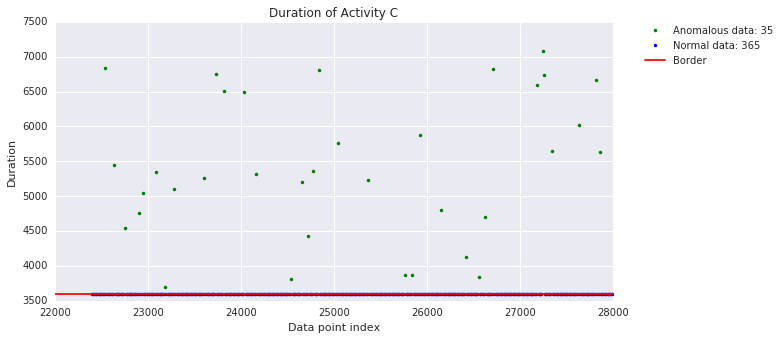

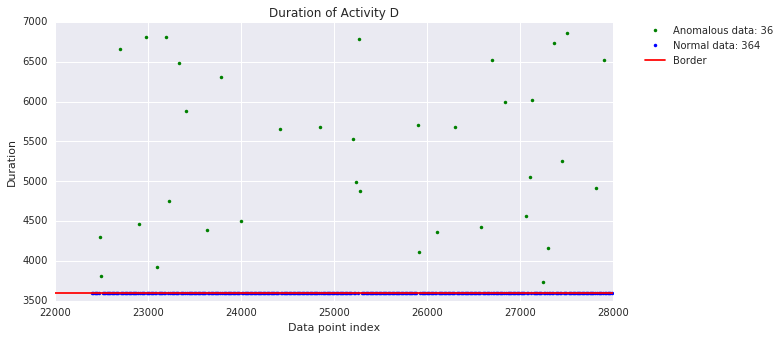

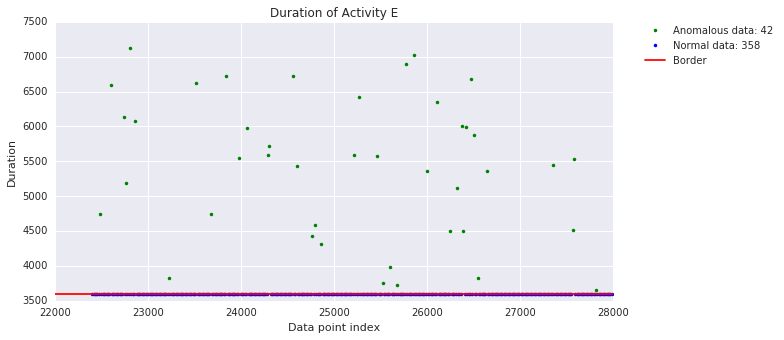

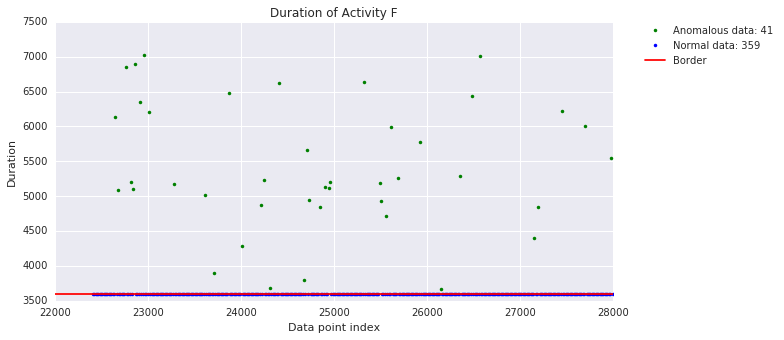

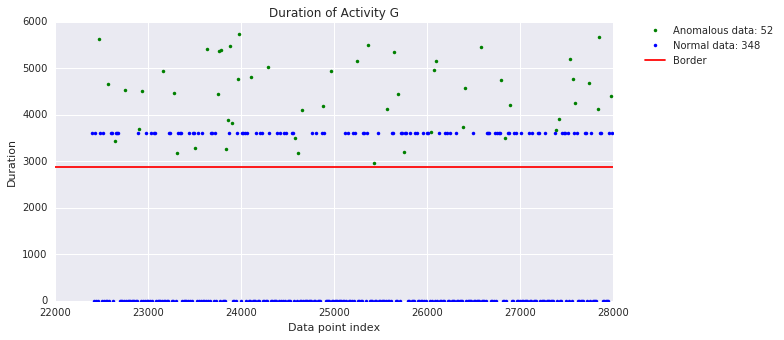

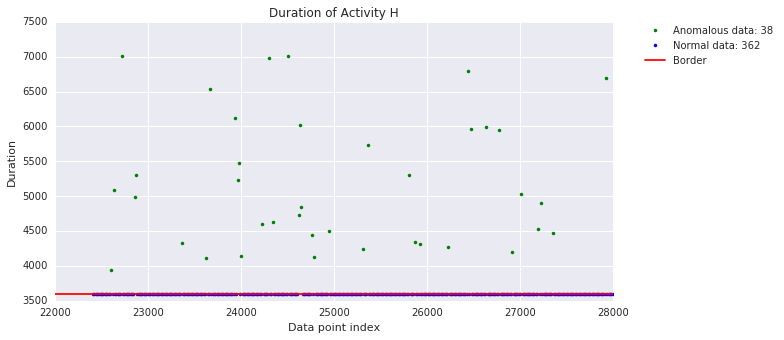

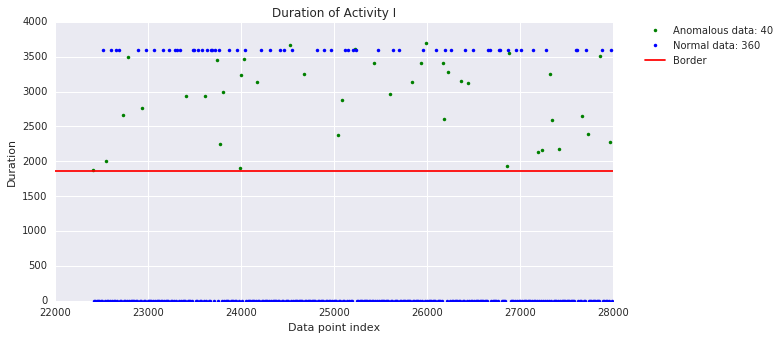

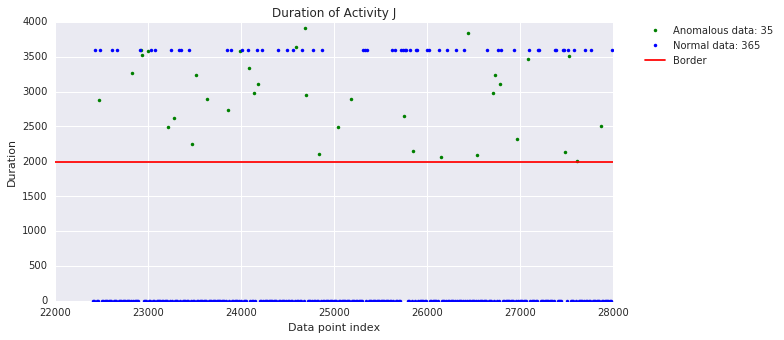

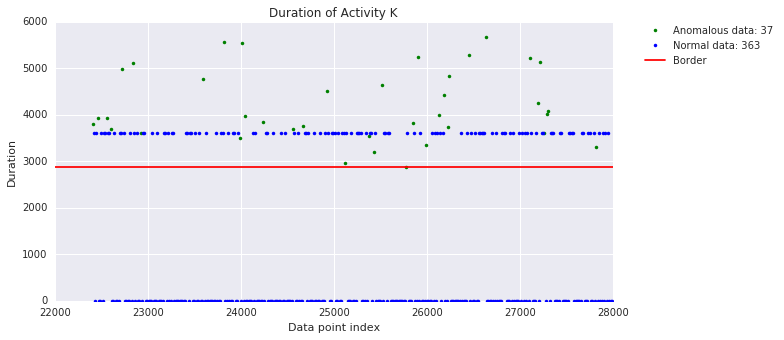

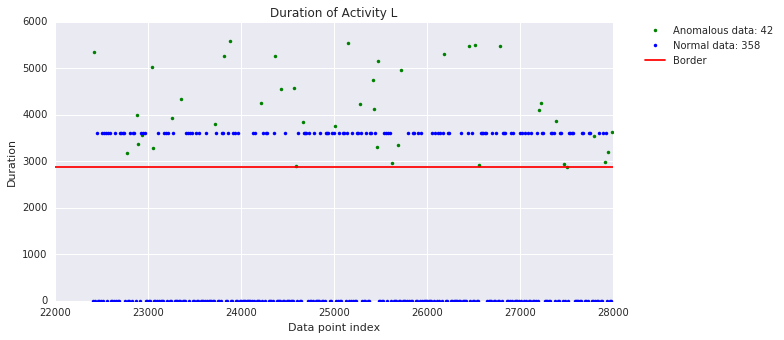

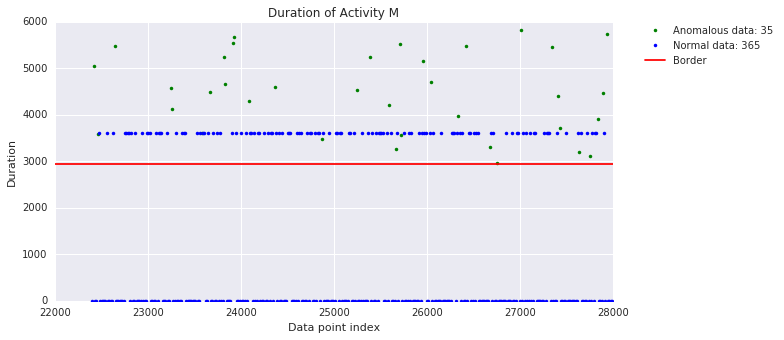

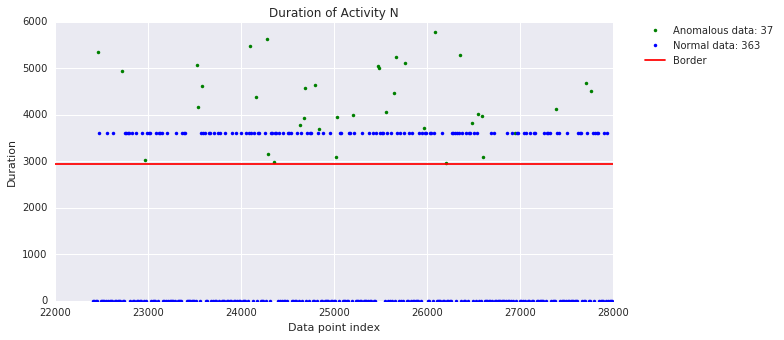

In [19]:
groupByActivity = temp_test.groupby(['Activity'])

for act, group in groupByActivity:
    plotDuration(act, group, False)